## Spark SQL

Spark SQL是架在Spark core之上允许我们用SQL去操作大型数据库的高级层。

首先你需要了解的是，**我们需要在之前的`SparkContext`基础上架上一层`SQLContext`，然后才能完成后续的SQL。**<br>
如下：

In [2]:
from pyspark import SparkContext
sc = SparkContext('local', 'pyspark')

In [3]:
from pyspark import SQLContext, Row
sqlCtx = SQLContext(sc)

Spark SQL得到的RDD，可以转成类似pandas中大家熟悉的dataframe格式。<br>
对的，大家依旧可以把它想象成Excel中的图表，每个item都是一个`Row`

最简单的初始化`Dataframe`方法是先用`sc.parallelize`产出一个RDD，如下：

In [4]:
rdd = sc.parallelize([
        Row(name='John', home='Brussels', age=35),
        Row(name='Jack', home='Brussels', age=32),
        Row(name='Jane', home='Leuven', age=42),
        Row(name='Jill', home='Mechelen', age=53),
    ])

然后生成一个dataframe：

In [5]:
df = sqlCtx.createDataFrame(rdd)
df.registerTempTable("people")

当然，你也可以在Hive表里使用Spark SQL

刚才的table建好后，你就可以在上面跑各种SQL了:

In [6]:
avgAge = sqlCtx.sql(
    """SELECT
           home,
           AVG(age) AS mean
       FROM people
       GROUP BY home"""
)
avgAge

DataFrame[home: string, mean: double]

大家都知道在一般的数据表里执行SQL之后得到的还是一份表格式的数据，在Spark SQL执行完之后，你得到的依旧是一个SchemaRDD。

In [7]:
avgAge.collect()

[Row(home=u'Mechelen', mean=53.0),
 Row(home=u'Leuven', mean=42.0),
 Row(home=u'Brussels', mean=33.5)]

别忘了学习到的RDD上的transform或者action等operation，**同时你可以用`row.fieldname`取出来某个field**，如下:

In [9]:
print(avgAge.rdd
      .map(lambda row: "Average age in {0} is {1} years"
                        .format(row.home, row.mean))
      .reduce(lambda x, y: x + "\n" + y))

Average age in Mechelen is 53.0 years
Average age in Leuven is 42.0 years
Average age in Brussels is 33.5 years


### <font color='red'>练习作业</font><br>
**回顾一下，我们可以在pandas里定义这样一个dataframe**
```
data = {
    'country': ['BE', 'BE', 'BE', 'NL', 'NL', 'NL'],
    'year': [1913, 1950, 2003, 1913, 1950, 2003],
    'gdp_per_capita': [4220, 5462, 21205, 4049, 5996, 21480]
}
frame = DataFrame(data)
```
**请大家在Spark中生成一个Dataframe，再做一个简单的SQL分析：求这3年各首都的平均GDP**

In [14]:
rdd = sc.parallelize([
        Row(country='BE', year=1913, gdp_per_capita=4220),
        Row(country='BE', year=1950, gdp_per_capita=5462),
        Row(country='BE', year=2003, gdp_per_capita=21205),
        Row(country='NL', year=1913, gdp_per_capita=4049),
        Row(country='NL', year=1950, gdp_per_capita=5996),
        Row(country='NL', year=2003, gdp_per_capita=21480)
    ])
df = sqlCtx.createDataFrame(rdd)
df.registerTempTable("GDP")
print df.head(6)
avgGDP = sqlCtx.sql(
    """SELECT
           country,
           AVG(gdp_per_capita) AS mean
       FROM people
       GROUP BY country"""
)
avgGDP.collect()

[Row(country=u'BE', gdp_per_capita=4220, year=1913), Row(country=u'BE', gdp_per_capita=5462, year=1950), Row(country=u'BE', gdp_per_capita=21205, year=2003), Row(country=u'NL', gdp_per_capita=4049, year=1913), Row(country=u'NL', gdp_per_capita=5996, year=1950), Row(country=u'NL', gdp_per_capita=21480, year=2003)]


[Row(country=u'NL', mean=10508.333333333334),
 Row(country=u'BE', mean=10295.666666666666)]

### <font color='red'>练习作业</font><br>
**`sc.textFile`, `union` 和 `map`练习。 把提供的`names`数据集构建成一个Dataframe，包含`year`, `name`, `sex`和`births`，把它注册成一个表`"names"`**

**1. 求从1939到1945年美国总出生的人口**  

**2. 统计从1880到2014每一年叫`"Mary"`的宝宝出生数目，并用matplotlib绘制成图像**

**3. 统计从1880到2014每一年男孩和女孩的出生数，并绘制在一张图中。**

**4. 统计出来每一年出生的宝宝频次最高的前1000个名字，以及它们的占比，并用绘图的方式去展示出来**

In [57]:
#题目有错：names数据集不存在birth字段
import os
start_year = 1880
end_year = 2014

cwd = os.getcwd()
crt_year = None
def parseNamedata(line):
    line = line.split(",")
    return (Row(
            year = crt_year ,
            name = line[0] ,
            sex = line[1] ,
            id = line[2]
    ), 1)
#crt_year = start_year
#rdd = sc.textFile("file://" + cwd + "/names/yob1880.txt")
#rdd = rdd.map(parseNamedata).filter(lambda s : s[1] == 1).map(lambda (x, y) : x)
rdd = sc.parallelize([])
for year in range(start_year, end_year + 1):
    crt_year = year
    filedir = "file://" + cwd + "/names/yob" + str(year) + ".txt"
    tmp = sc.textFile(filedir)
    tmp = tmp.map(parseNamedata).filter(lambda s : s[1] == 1).map(lambda (x, y) : x)
    rdd = rdd.union(tmp)
df = sqlCtx.createDataFrame(rdd)
df.registerTempTable("names")

In [58]:
#1. 求从1939到1945年美国总出生的人口
totalcount = sqlCtx.sql(
    """SELECT
           name
       FROM names
       WHERE year >= 1939 and year <= 1945 """
)
totalcount.count()

63973

In [75]:
#2. 统计从1880到2014每一年叫"Mary"的宝宝出生数目，并用matplotlib绘制成图像
#1880???1881
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

Marycount = sqlCtx.sql(
    """SELECT
           year,
           count(year) AS count
       FROM names
       WHERE name = 'Mary'
       GROUP BY year
       ORDER BY year"""
)
#Marycount.collect()

(0, 5)

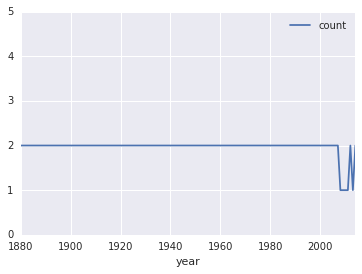

In [77]:
import numpy as np
Marydata = Marycount.toPandas()
_, x = plt.subplots()
Marydata.set_index('year', inplace = True)
Marydata.plot(ax = x)
x.set_ylim([0, 5])

In [80]:
#3. 统计从1880到2014每一年男孩和女孩的出生数，并绘制在一张图中。
Sexcount = sqlCtx.sql(
    """SELECT
           year,
           sex,
           count(sex) AS count
       FROM names
       GROUP BY year,sex
       ORDER BY year"""
)
Sexcount.collect()

[Row(year=1880, sex=u'M', count=1058),
 Row(year=1880, sex=u'F', count=942),
 Row(year=1881, sex=u'M', count=997),
 Row(year=1881, sex=u'F', count=938),
 Row(year=1882, sex=u'F', count=1028),
 Row(year=1882, sex=u'M', count=1099),
 Row(year=1883, sex=u'M', count=1030),
 Row(year=1883, sex=u'F', count=1054),
 Row(year=1884, sex=u'M', count=1125),
 Row(year=1884, sex=u'F', count=1172),
 Row(year=1885, sex=u'M', count=1097),
 Row(year=1885, sex=u'F', count=1197),
 Row(year=1886, sex=u'F', count=1282),
 Row(year=1886, sex=u'M', count=1110),
 Row(year=1887, sex=u'F', count=1306),
 Row(year=1887, sex=u'M', count=1067),
 Row(year=1888, sex=u'M', count=1177),
 Row(year=1888, sex=u'F', count=1474),
 Row(year=1889, sex=u'F', count=1479),
 Row(year=1889, sex=u'M', count=1111),
 Row(year=1890, sex=u'F', count=1534),
 Row(year=1890, sex=u'M', count=1161),
 Row(year=1891, sex=u'F', count=1533),
 Row(year=1891, sex=u'M', count=1127),
 Row(year=1892, sex=u'M', count=1260),
 Row(year=1892, sex=u'F', co

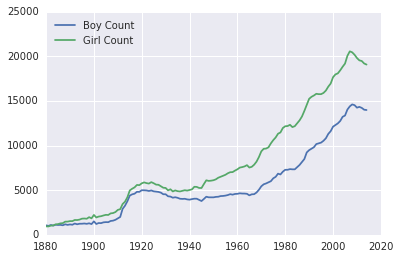

In [95]:
Sexdata = Sexcount.toPandas()
boydata = Sexdata[Sexdata.sex == 'M']
girldata = Sexdata[Sexdata.sex == 'F']
x_data = range(end_year - start_year + 1)
_, ax = plt.subplots()
ax.plot(x_data, boydata['count'], label='Boy Count')
ax.plot(x_data, girldata['count'], label='Girl Count')
ax.legend(loc='upper left')
ax.set_xticklabels(range(start_year, end_year + 20, 20))

In [134]:
#4. 统计出来每一年出生的宝宝频次最高的前1000个名字，以及它们的占比，并用绘图的方式去展示出来
#应该是表里最高的1000个名字，按每年算图太多。且无论如何区分度都不好
#Top语句不能用
Top1000count = sqlCtx.sql(
    """SELECT
           name,
           count(name) AS count
       FROM names
       GROUP BY name
       ORDER BY count DESC"""
)
Top1000count.collect()

[Row(name=u'Marion', count=270),
 Row(name=u'James', count=270),
 Row(name=u'Sidney', count=270),
 Row(name=u'Francis', count=270),
 Row(name=u'Jessie', count=270),
 Row(name=u'Johnnie', count=270),
 Row(name=u'Ollie', count=270),
 Row(name=u'Jean', count=270),
 Row(name=u'John', count=270),
 Row(name=u'Jesse', count=270),
 Row(name=u'Joseph', count=270),
 Row(name=u'Tommie', count=270),
 Row(name=u'Robert', count=270),
 Row(name=u'Lee', count=270),
 Row(name=u'Leslie', count=270),
 Row(name=u'William', count=270),
 Row(name=u'Charlie', count=269),
 Row(name=u'Charles', count=269),
 Row(name=u'June', count=269),
 Row(name=u'Elizabeth', count=269),
 Row(name=u'Henry', count=269),
 Row(name=u'Ira', count=268),
 Row(name=u'Thomas', count=268),
 Row(name=u'Ivy', count=267),
 Row(name=u'Lonnie', count=267),
 Row(name=u'Anna', count=267),
 Row(name=u'Cleo', count=267),
 Row(name=u'George', count=267),
 Row(name=u'Lou', count=266),
 Row(name=u'Dana', count=266),
 Row(name=u'Frances', count=26

([<matplotlib.patches.Wedge at 0x7fb9b7820d10>,
  <matplotlib.text.Text at 0x7fb9aeb44310>])

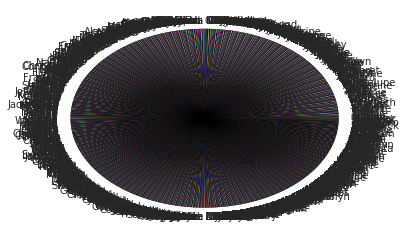

In [130]:
#此题出的并不好，无论按年分，还是算总体，名字的分布都趋于接近。使用饼状图展示1000项比例也使得效果不好
#使用Another项存在的问题：another占比过高，效果还是很差。
Top1000data = Top1000count.toPandas()[:1000]
Top1000data.set_index("name", inplace=True)
Top1000sum = Top1000data['count'].sum()
Top1000data['fracs'] = Top1000data['count'] / Top1000sum
_, ax = plt.subplots()
ax.pie(Top1000data['fracs'], labels=Top1000data.index)

## 更多知识
到此为止，应该Spark核心知识与Spark SQL知识你都有一些了解了，其实有更多的Spark SQL知识，比如:
* Complex Joins
* Subqueries
* Basic math functions
* User-defined functions (UDFs)
* ...

完整的文档可以看[这里](https://spark.apache.org/docs/2.1.0/sql-programming-guide.html#compatibility-with-apache-hive)